Training Progress:  10%|█         | 102/1000 [00:06<01:02, 14.46it/s]

Episode 100, Average Reward: 23.34


Training Progress:  20%|██        | 202/1000 [00:15<01:31,  8.69it/s]

Episode 200, Average Reward: 38.32


Training Progress:  30%|███       | 300/1000 [00:38<04:11,  2.79it/s]

Episode 300, Average Reward: 120.63


Training Progress:  40%|████      | 400/1000 [01:09<03:40,  2.72it/s]

Episode 400, Average Reward: 157.50


Training Progress:  50%|█████     | 500/1000 [01:48<04:30,  1.85it/s]

Episode 500, Average Reward: 201.09


Training Progress:  60%|██████    | 600/1000 [02:45<03:04,  2.17it/s]

Episode 600, Average Reward: 298.23


Training Progress:  70%|███████   | 700/1000 [03:43<01:59,  2.51it/s]

Episode 700, Average Reward: 303.75


Training Progress:  80%|████████  | 800/1000 [04:32<01:46,  1.88it/s]

Episode 800, Average Reward: 254.54


Training Progress:  90%|█████████ | 900/1000 [05:34<00:40,  2.49it/s]

Episode 900, Average Reward: 327.73


Training Progress: 100%|██████████| 1000/1000 [06:56<00:00,  2.40it/s]


Episode 1000, Average Reward: 422.97


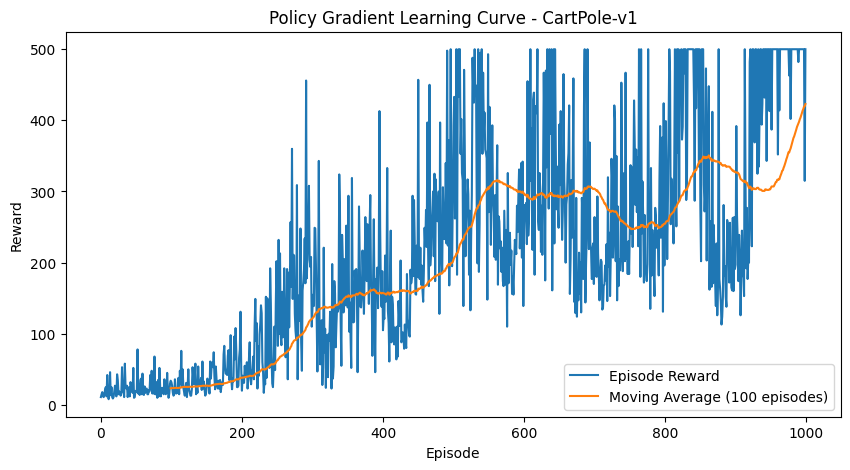


Evaluating trained policy:
Mean Reward: 497.978
Standard Deviation: 15.190441599900906


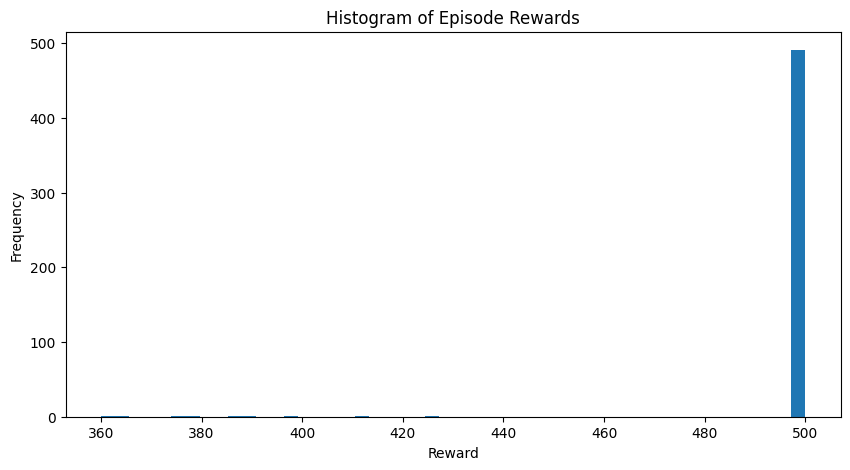


Rendering the trained policy:
Episode 1 Reward: 500.0
Episode 2 Reward: 500.0
Episode 3 Reward: 500.0
Episode 4 Reward: 500.0
Episode 5 Reward: 500.0


In [14]:
import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def set_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

SEED = 42  # You can change this to any integer
set_seeds(SEED)

class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(PolicyNetwork, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
            nn.Softmax(dim=-1)  # Add Softmax as the final layer
        )

    def forward(self, x):
        return self.fc(x)

def train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate):
    env = gym.make(env_name)
    env.reset(seed=SEED)
    input_dim = env.observation_space.shape[0]
    output_dim = env.action_space.n

    policy = PolicyNetwork(input_dim, output_dim).to(device)
    optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

    episode_rewards = []
    moving_average_rewards = []

    for episode in tqdm(range(num_episodes), desc="Training Progress"):
        state, _ = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        while not done:
            state_tensor = torch.FloatTensor(state).to(device)#.unsqueeze(0).to(device)
            action_probs = policy(state_tensor)  # No need for softmax here anymore
            dist = Categorical(action_probs)
            action = dist.sample()
            
            next_state, reward, terminated, truncated, _ = env.step(action.item())
            done = terminated or truncated
            
            log_probs.append(dist.log_prob(action))
            rewards.append(reward)
            
            state = next_state
        
        episode_reward = sum(rewards)
        episode_rewards.append(episode_reward)
        
        if len(episode_rewards) >= 100:
            moving_avg = np.mean(episode_rewards[-100:])
            moving_average_rewards.append(moving_avg)
        
        discounted_rewards = []
        R = 0
        for r in reversed(rewards):
            R = r + discount_factor * R
            discounted_rewards.insert(0, R)
        discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)
        
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
        loss = []
        for log_prob, R in zip(log_probs, discounted_rewards):
            loss.append(-log_prob * R)
        loss = torch.stack(loss).sum()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (episode + 1) % 100 == 0:
            tqdm.write(f"Episode {episode + 1}, Average Reward: {np.mean(episode_rewards[-100:]):.2f}")

    return policy, episode_rewards, moving_average_rewards

def evaluate(env, policy, num_episodes=500):
    episode_rewards = []
    for _ in range(num_episodes):
        state, _ = env.reset()
        total_reward = 0
        done = False
        while not done:
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = policy(state)
            action = torch.argmax(action_probs).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
        episode_rewards.append(total_reward)
    
    return episode_rewards

def render_policy(env_name, policy, num_episodes=5):
    env = gym.make(env_name, render_mode="human")
    for episode in range(num_episodes):
        state, _ = env.reset()
        done = False
        total_reward = 0
        while not done:
            env.render()
            state = torch.FloatTensor(state).unsqueeze(0).to(device)
            action_probs = policy(state)
            action = torch.argmax(action_probs).item()
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            state = next_state
            total_reward += reward
            time.sleep(0.02)  # Add a small delay to make the rendering visible
        print(f"Episode {episode + 1} Reward: {total_reward}")
    env.close()

# Training
env_name = "CartPole-v1"
num_episodes = 1000
discount_factor = 0.95
learning_rate = 0.001

trained_policy, episode_rewards, moving_average_rewards = train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate)

# Plotting training progress
plt.figure(figsize=(10, 5))
plt.plot(episode_rewards, label='Episode Reward')
plt.plot(range(99, len(episode_rewards)), moving_average_rewards, label='Moving Average (100 episodes)')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title(f'Policy Gradient Learning Curve - {env_name}')
plt.legend()
plt.show()

# Evaluation
print("\nEvaluating trained policy:")
env = gym.make(env_name)
eval_rewards = evaluate(env, trained_policy)

print(f'Mean Reward: {np.mean(eval_rewards)}')
print(f'Standard Deviation: {np.std(eval_rewards)}')

# Plotting evaluation results
plt.figure(figsize=(10, 5))
plt.hist(eval_rewards, bins=50)
plt.title('Histogram of Episode Rewards')
plt.xlabel('Reward')
plt.ylabel('Frequency')
plt.show()

# Render the policy
print("\nRendering the trained policy:")
render_policy(env_name, trained_policy)

In [15]:
# import gym
# import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.distributions import Categorical
# import matplotlib.pyplot as plt
# from tqdm import tqdm

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# class PolicyNetwork(nn.Module):
#     def __init__(self, input_dim, output_dim):
#         super(PolicyNetwork, self).__init__()
#         self.fc = nn.Sequential(
#             nn.Linear(input_dim, 128),
#             nn.ReLU(),
#             nn.Linear(128, output_dim)
#         )

#     def forward(self, x):
#         return self.fc(x)

# def train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate):
#     env = gym.make(env_name)
#     input_dim = env.observation_space.shape[0]
#     output_dim = env.action_space.n

#     policy = PolicyNetwork(input_dim, output_dim).to(device)
#     optimizer = optim.Adam(policy.parameters(), lr=learning_rate)

#     episode_rewards = []
#     moving_average_rewards = []

#     for episode in tqdm(range(num_episodes), desc="Training Progress"):
#         state, _ = env.reset()
#         log_probs = []
#         rewards = []
#         done = False
        
#         while not done:
#             state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
#             action_probs = torch.softmax(policy(state_tensor), dim=1)
#             dist = Categorical(action_probs)
#             action = dist.sample()
            
#             next_state, reward, terminated, truncated, _ = env.step(action.item())
#             done = terminated or truncated
            
#             log_probs.append(dist.log_prob(action))
#             rewards.append(reward)
            
#             state = next_state
        
#         episode_reward = sum(rewards)
#         episode_rewards.append(episode_reward)
        
#         if len(episode_rewards) >= 100:
#             moving_avg = np.mean(episode_rewards[-100:])
#             moving_average_rewards.append(moving_avg)
        
#         discounted_rewards = []
#         R = 0
#         for r in reversed(rewards):
#             R = r + discount_factor * R
#             discounted_rewards.insert(0, R)
#         discounted_rewards = torch.FloatTensor(discounted_rewards).to(device)
        
#         discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-9)
        
#         loss = []
#         for log_prob, R in zip(log_probs, discounted_rewards):
#             loss.append(-log_prob * R)
#         loss = torch.stack(loss).sum()
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         if (episode + 1) % 100 == 0:
#             tqdm.write(f"Episode {episode + 1}, Average Reward: {np.mean(episode_rewards[-100:]):.2f}")

#     return policy, episode_rewards, moving_average_rewards

# def evaluate(env, policy, num_episodes=500):
#     episode_rewards = []
#     for _ in range(num_episodes):
#         state, _ = env.reset()
#         total_reward = 0
#         done = False
#         while not done:
#             state = torch.FloatTensor(state).unsqueeze(0).to(device)
#             action_probs = policy(state)
#             action = torch.argmax(action_probs).item()
#             next_state, reward, terminated, truncated, _ = env.step(action)
#             done = terminated or truncated
#             state = next_state
#             total_reward += reward
#         episode_rewards.append(total_reward)
    
#     return episode_rewards

# # Training
# env_name = "CartPole-v1"
# num_episodes = 1000
# discount_factor = 0.99
# learning_rate = 0.001

# trained_policy, episode_rewards, moving_average_rewards = train_policy_gradient(env_name, num_episodes, discount_factor, learning_rate)

# # Plotting training progress
# plt.figure(figsize=(10, 5))
# plt.plot(episode_rewards, label='Episode Reward')
# plt.plot(range(99, len(episode_rewards)), moving_average_rewards, label='Moving Average (100 episodes)')
# plt.xlabel('Episode')
# plt.ylabel('Reward')
# plt.title(f'Policy Gradient Learning Curve - {env_name}')
# plt.legend()
# plt.show()

# # Evaluation
# print("\nEvaluating trained policy:")
# env = gym.make(env_name)
# eval_rewards = evaluate(env, trained_policy)

# print(f'Mean Reward: {np.mean(eval_rewards)}')
# print(f'Standard Deviation: {np.std(eval_rewards)}')

# # Plotting evaluation results
# plt.figure(figsize=(10, 5))
# plt.hist(eval_rewards, bins=50)
# plt.title('Histogram of Episode Rewards')
# plt.xlabel('Reward')
# plt.ylabel('Frequency')
# plt.show()